# Počítačový návrh léčiv, 2. cvičení
Jiří Reiniš

In [1]:
import sys
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
suppl = Chem.SDMolSupplier("../../data/drugbank.sdf")

#### Úkol 1: napsat funkci, co mi řekne, která léčiva z DrugBank nesplňují RO5? (Lipinského pravidla pěti)

In [3]:
# vyfiltruje jenom funkcni a jinak normalni zaznamy
mols = [m for m in suppl if m]

RDKit WARNING: [18:49:04]  S group DAT ignored on line 2516
RDKit WARNING: [18:49:04]  S group DAT ignored on line 2516
RDKit WARNING: [18:49:04]  S group DAT ignored on line 2516
RDKit WARNING: [18:49:04]  S group DAT ignored on line 2516
RDKit WARNING: [18:49:04]  S group DAT ignored on line 15552
RDKit WARNING: [18:49:04]  S group DAT ignored on line 15552
RDKit WARNING: [18:49:04]  S group DAT ignored on line 15552
RDKit WARNING: [18:49:04]  S group DAT ignored on line 15552
RDKit ERROR: [18:49:04] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [18:49:04] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [18:49:04] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [18:49:04] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [18:49:04]  S group GEN ignored on line 102860
RDKit ERROR: [18:49:04] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [18:49:04]  Unhand

RDKit ERROR: [18:49:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 9 10
RDKit ERROR: 
RDKit ERROR: [18:49:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [18:49:05] ERROR: Could not sanitize molecule ending on line 447465
RDKit ERROR: [18:49:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [18:49:05] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [18:49:05] ERROR: Could not sanitize molecule ending on line 466177
RDKit ERROR: [18:49:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [18:49:05] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 17
RDKit ERROR: 
RDKit ERROR: [18:49:05] ERROR: Could not sanitize molecule ending on line 468852
RDKit ERROR: [18:49:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 17
RDKit ERROR: 
RDKit ERROR: [18:49:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit ERRO

RDKit ERROR: [18:49:05] ERROR: Explicit valence for atom # 4 F, 2, is greater than permitted
RDKit ERROR: [18:49:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [18:49:05] ERROR: Could not sanitize molecule ending on line 659994
RDKit ERROR: [18:49:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [18:49:05]  Unhandled CTAB feature: S group SRU on line: 754017. Molecule skipped.
RDKit ERROR: [18:49:06] Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [18:49:06] ERROR: Could not sanitize molecule ending on line 995692
RDKit ERROR: [18:49:06] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [18:49:06]  Unhandled CTAB feature: S group SRU on line: 1148513. Molecule skipped.
RDKit ERROR: [18:49:06] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [18:49:06] ERROR: Could not sanitize molecule ending on line 1151592


In [4]:
# molekulova hmotnost musi byt mensi nez 500
def lipinski_mw(m):
    return Descriptors.ExactMolWt(m) <= 500

# rozdelovaci koeficient musi byt mensi nez 5
def lipinski_logp(m):
    return Descriptors.MolLogP(m) < 5

# pocet donoru vodikovych vazeb musi byt mensi rovno 5
def lipinski_hbd(m):
    return Descriptors.NumHDonors(m) <= 5

# pocet akceptoru vodikovych vazeb musi byt mensi rovno 10
def lipinski_hba(m):
    return Descriptors.NumHAcceptors(m) <= 10

# dohromady to urci:
def lipinski(m):
    return sum([lipinski_mw(m), lipinski_logp(m), lipinski_hbd(m), lipinski_hba(m)]) > 2


#### Úkol 1a: rozdělit dataset podle toho, zda molekula splňuje RO5 a vykreslit prvních pár nesplňujících.

In [5]:
failed = [m for m in mols if lipinski(m)]
success = [m for m in mols if not lipinski(m)]
print(len(failed))
print(len(success))

6382
728


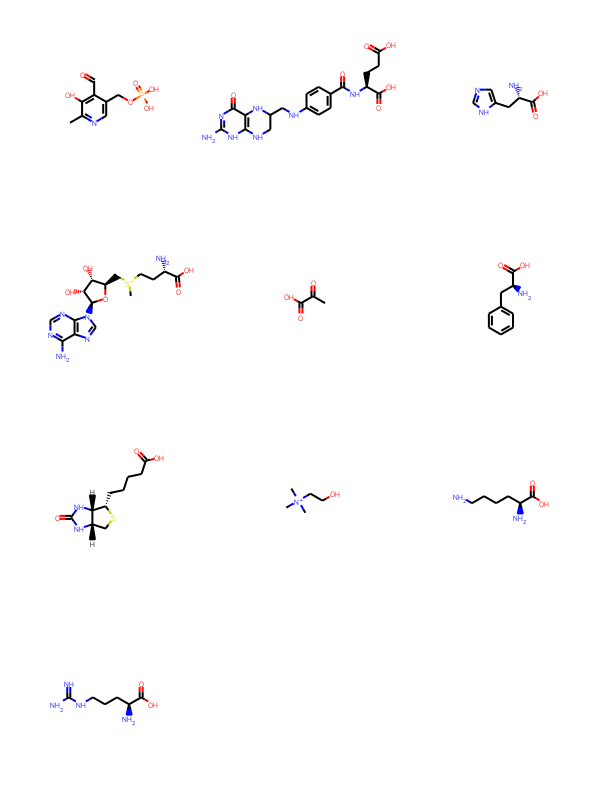

In [7]:
Draw.MolsToGridImage(failed[:10], molsPerRow=3, subImgSize=(200, 200))

#### Úkol 3: Dataset PAINS ve SMARTS formatu

* Nyní chceme odfiltrovat struktury, ktery obsahují jako podstruktury PAINS (Pan-assay interference compounds). Tyto podstruktury máme popsány pomocí formátu SMARTS, což se dá chápat jako obdoba regulárního výrazu.

* Máme tedy načíst všechna SMARTS pravidla a u všech molekul se podívat, zda obsahují nějakou z pravidly definovaných substruktur. Pokud ano, vyhodíme je z našeho datasetu.

In [9]:
# nacteni souboru s PAINS pravidly, vysledek je seznam dvojic
# dvojice: [substruktura, popis]
patterns = []
with open('../../data/PAINS/p_l15.txt') as f:
    for line in f:
        pattern, text = line.strip().split('\t')
        patterns.append([Chem.MolFromSmarts(pattern), text.lstrip("<regId=\"").rstrip("\">")])

In [10]:
# vezme seznam substruktur a molekulu, vrati vektor boolu indikujici, zda molekula prislusnou substrukturu obsahuje
def apply_substructures(m, substructures):
    return [m.HasSubstructMatch(substructure) for substructure in substructures]

In [16]:
# substruktury bez popisu
substructures = [pattern[0] for pattern in patterns]
# popisy bez substruktur
descriptions = [pattern[1] for pattern in patterns]

# do tehle promenne ulozim informace, zda molekula obsahuje PAINS substruktury
pains = []
for m in mols:
    pains.append((apply_substructures(m, substructures)))

In [12]:
# jen pro kontrolu
print(len(pains), len(mols))

7110 7110


In [14]:
success_pains = []
failure_pains = []

for i, x in enumerate(pains):
    # molekula obsahuje nejakou substrukturu, tak ji dam stranou i s informaci, ktere substruktury obsahuje 
    if any(x):
        failure_pains.append([mols[i], x])
    # molekula neobsahuje zadne z definovanych substruktur
    else:
        success_pains.append(mols[i])

0


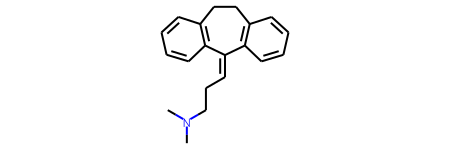

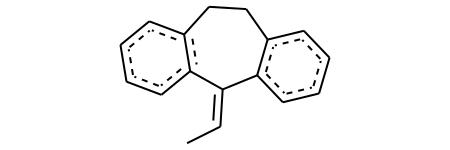

1


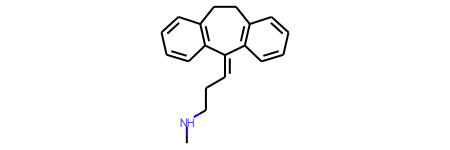

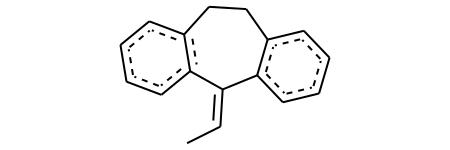

2


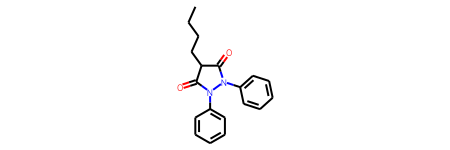

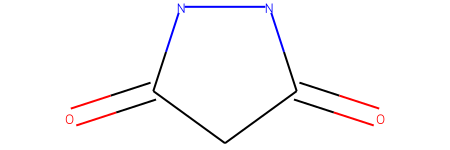

3


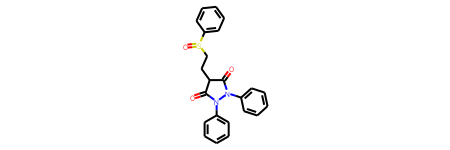

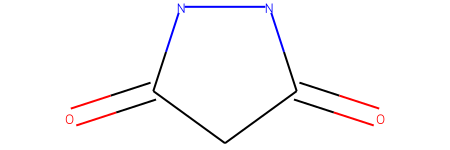

4


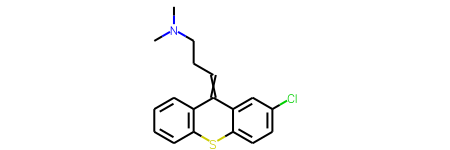

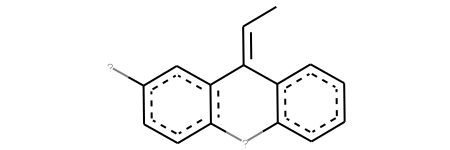

5


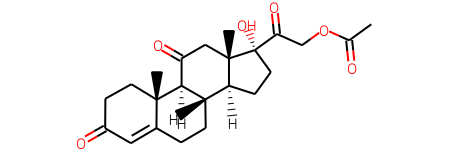

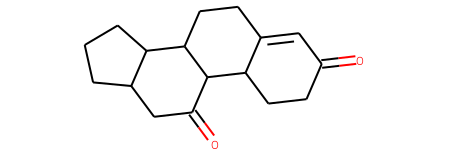

6


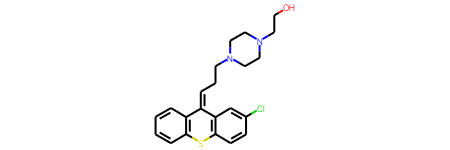

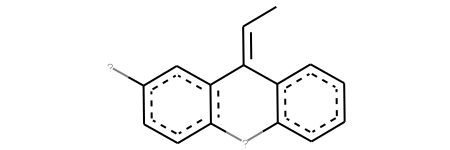

7


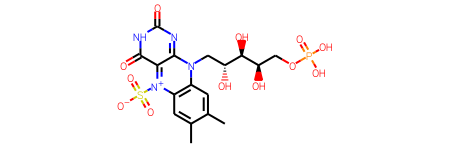

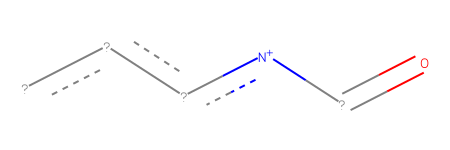

8


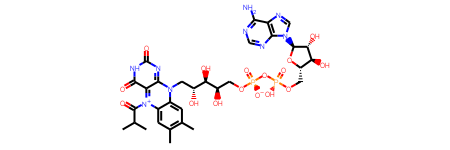

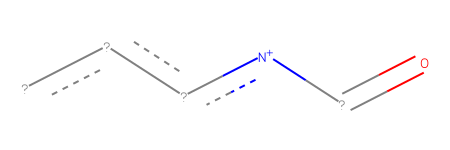

9


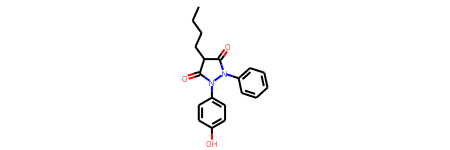

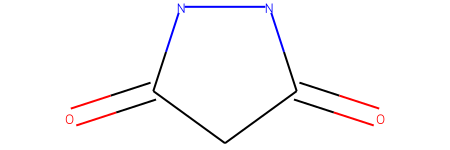

10


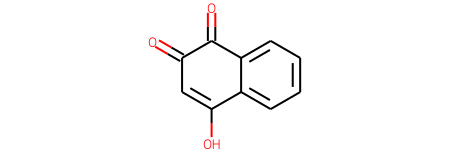

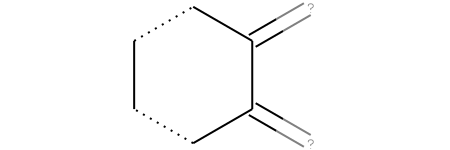

11


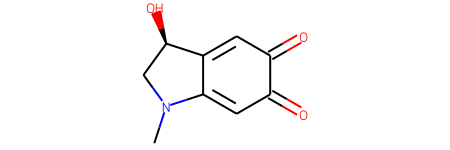

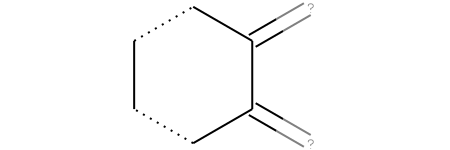

12


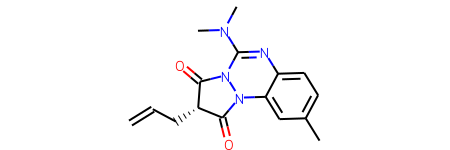

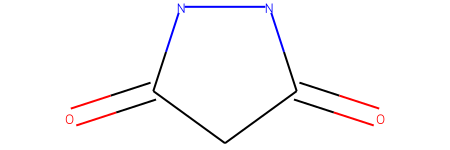

13


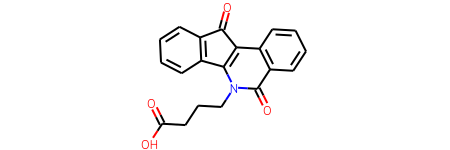

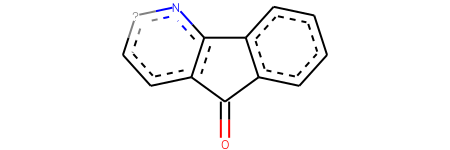

14


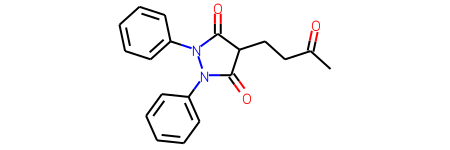

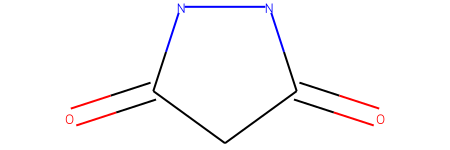

15


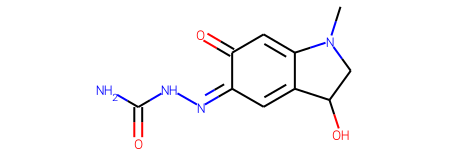

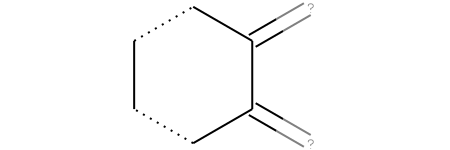

In [15]:
# vykreslim molekuly, kde to selhalo, plus jaky substruktury obsahovaly
# ano, vim, ze to je prasacky napsany
for i, (m, substructure_content) in enumerate(failure_pains):
    print(i)
    subs = [sub for (contains, sub) in (zip(substructure_content, substructures)) if contains]
    display(m)
    for sub in subs:
        display(sub)

Mělo by jich být 16.